In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Reading the data
ts = pd.read_csv('https://raw.githubusercontent.com/ml-mipt/ml-mipt-part2/master/2017/seminars/1_ts_esm/data/TimeSeries_Data10.csv', sep=',', decimal='.', parse_dates=True, dayfirst=True, index_col='Dates')
ts.index.names=['Timestamp']
ts = ts.sort_index()

seasonal_ts = pd.read_csv('https://raw.githubusercontent.com/aromanenko/AggregatingAlgorithm/master/data/seasonal_ts.csv', sep=';', parse_dates=True, dayfirst=True, index_col='Dates')
seasonal_ts.index.names=['Timestamp']

# Statsmodels 
Построение one-step-ahead предсказаний

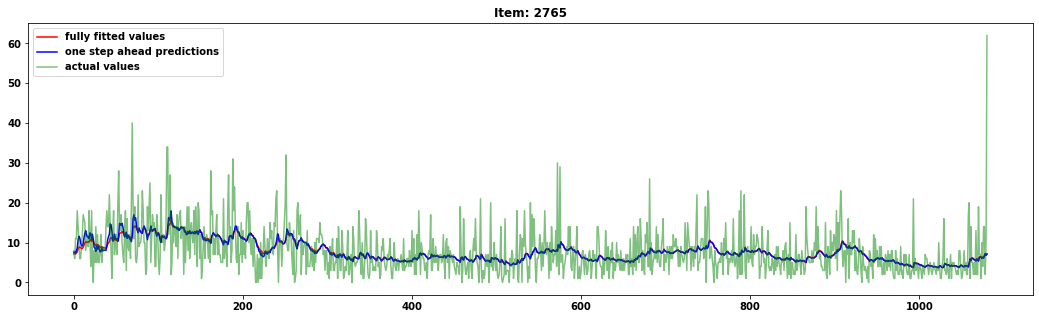

MSE значение между истинными значениями и предсказаниями, полученными one-step-ahead = 31871.193582
MSE значение между истинными значениями и предсказаниями, полученными "нечестным" способом = 31633.877818


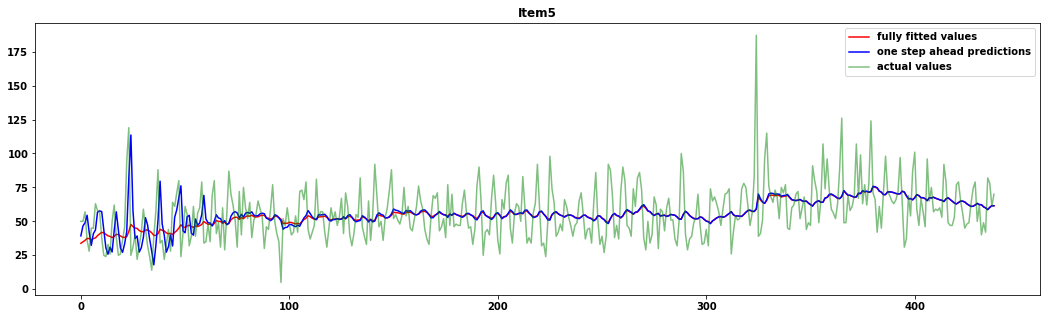

MSE значение между истинными значениями и предсказаниями, полученными one-step-ahead = 164085.667276
MSE значение между истинными значениями и предсказаниями, полученными "нечестным" способом = 156783.682768


In [3]:
#Для домашнего задания будет взят самый простой алгоритм экспоненциального сглаживания без подбора гиперпараметров
from statsmodels.tsa.api import Holt, ExponentialSmoothing, SimpleExpSmoothing

#Возьмём по одному ВР из имеющихся датасетов
test = ts['Item: 2765'].dropna().to_period(freq='D')
test2 = seasonal_ts['Item5'].dropna().to_period(freq='D')

for data in (test, test2):
    #Обучим алгоритм на всех данных для получения "нечестных" предсказаний
    fit = SimpleExpSmoothing(data).fit()
    fullfit = fit.fittedvalues
    one_step_pred = []
    
    #Начиная с 61 временного периода, обучим алгоритм на исторических данных и получим предсказание на 1 день вперёд
    for i in range(61, data.shape[0]):
        fit = SimpleExpSmoothing(data[:i]).fit()
        one_step_pred.append(fit.fittedfcast[-1])
    one_step_pred = np.array(one_step_pred)
    
    #Отрисуем оба графика
    fig = plt.figure(figsize=(18,5))
    plt.plot(np.array(fullfit[61:]), label='fully fitted values', color='red')
    plt.plot(one_step_pred, label='one step ahead predictions', color='blue')
    plt.plot(np.array(data[61:]), label='actual values', alpha=0.5, color='green')
    plt.title(data.name)
    plt.legend()
    plt.show()
    
    #Сравним результаты
    print('MSE значение между истинными значениями и предсказаниями, полученными one-step-ahead = {0:2f}'.format(np.sum(np.square(one_step_pred - np.array(data[61:])))))
    print('MSE значение между истинными значениями и предсказаниями, полученными "нечестным" способом = {0:2f}'.format(np.sum(np.square(np.array(fullfit[61:]) - np.array(data[61:])))))

## PyFlux

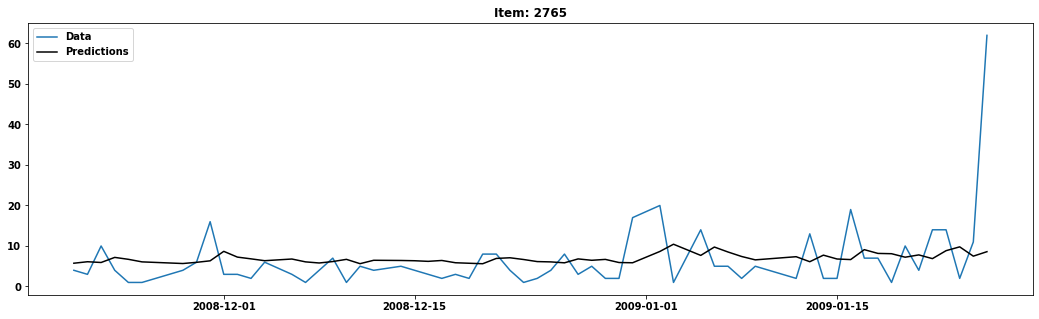

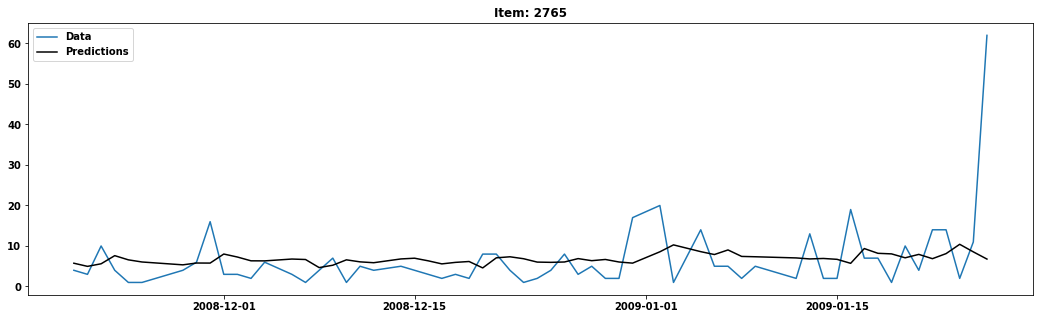

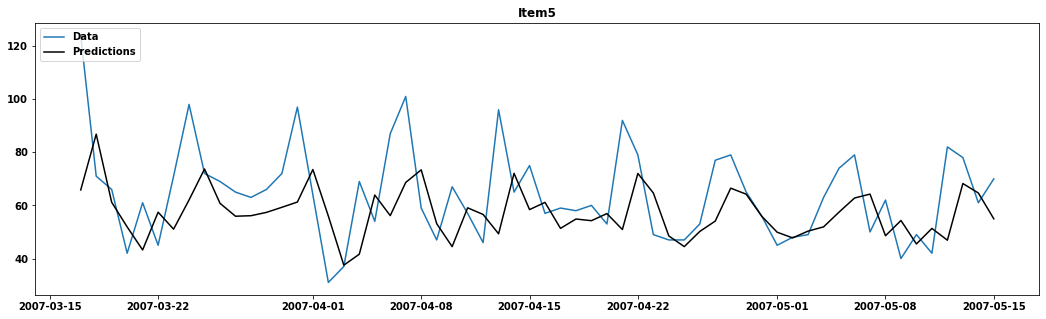

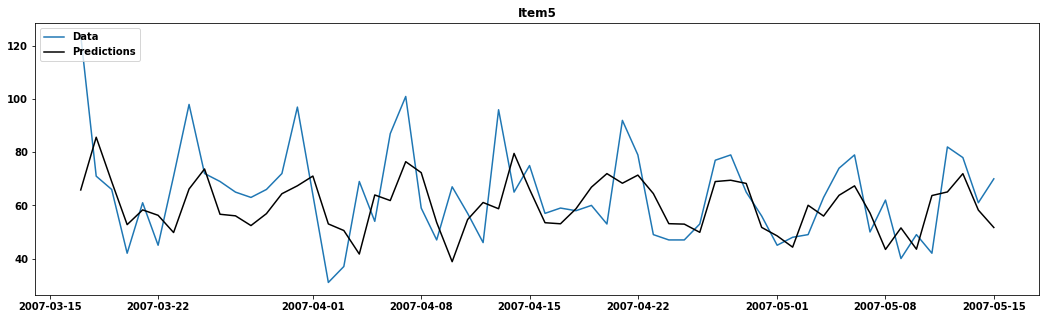

In [7]:
import pyflux as pf
data = pd.DataFrame(ts['Item: 2765'].dropna())
#Модуль pyflux даёт возможность моделировать часть выборки как out-of-sample данные
#Параметр fit_once отвечает за то, предсказывается ли период однажды или методом one-step-ahead
model = pf.ARIMA(data=data, ar=4, ma=4, family=pf.Normal())
model.plot_predict_is(h=60, fit_method='MLE', fit_once=True, figsize=(18,5))
model.plot_predict_is(h=60, fit_method='MLE', fit_once=False, figsize=(18,5))

data = pd.DataFrame(seasonal_ts['Item5'].dropna())
model = pf.ARIMA(data=data, ar=4, ma=4, family=pf.Normal())
model.plot_predict_is(h=60, fit_method='MLE', fit_once=True, figsize=(18,5))
model.plot_predict_is(h=60, fit_method='MLE', fit_once=False, figsize=(18,5))
#Минус этого способа заключается в том, что данная функция выдаёт лишь график,
#но не даёт способа вывести результаты в численном виде для дальнейшего сравнения

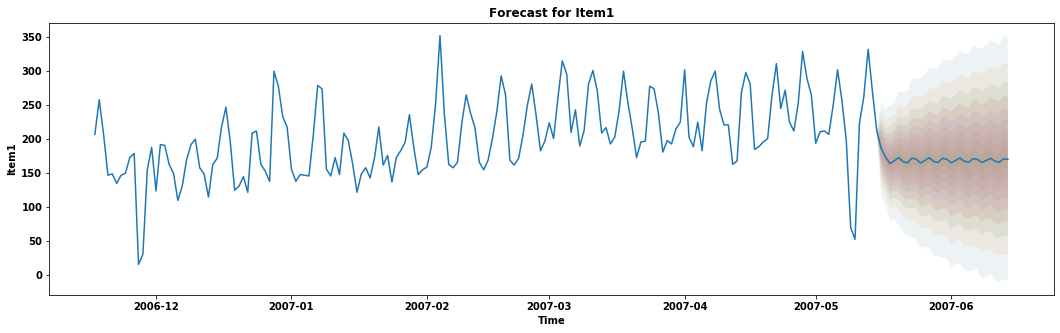

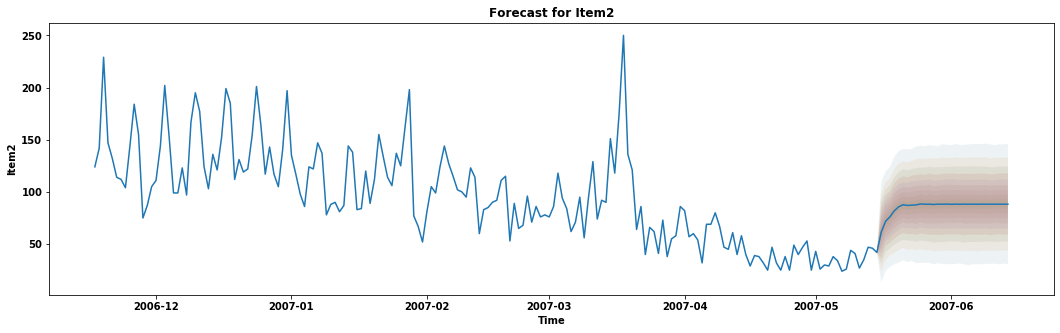

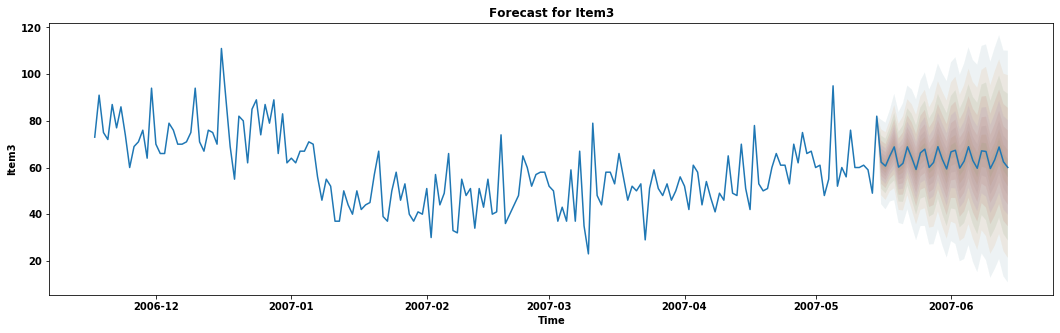

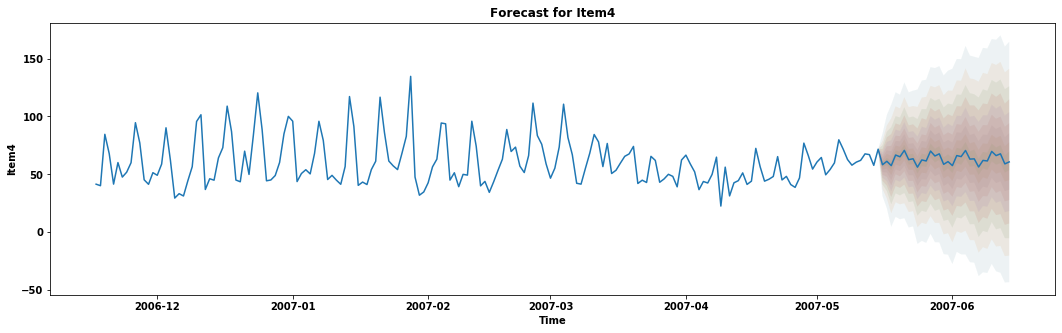

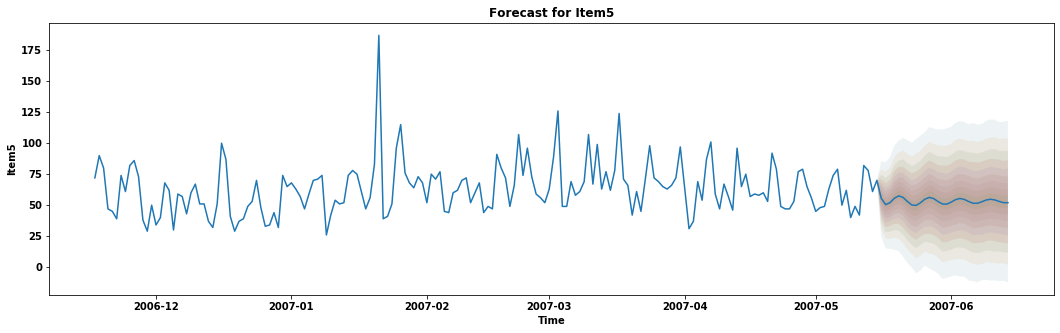

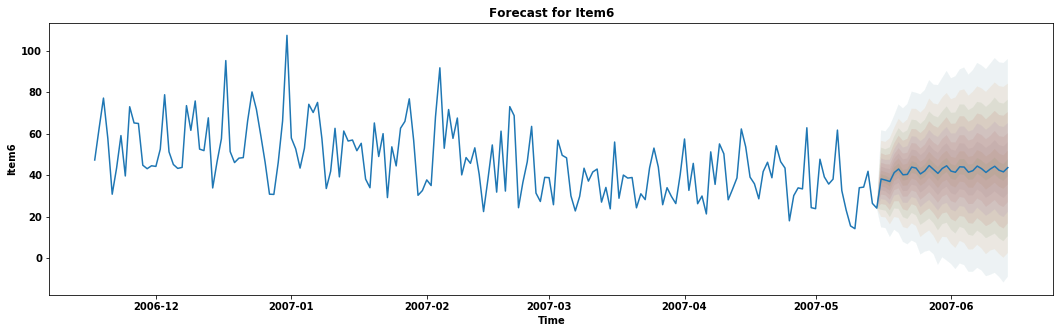

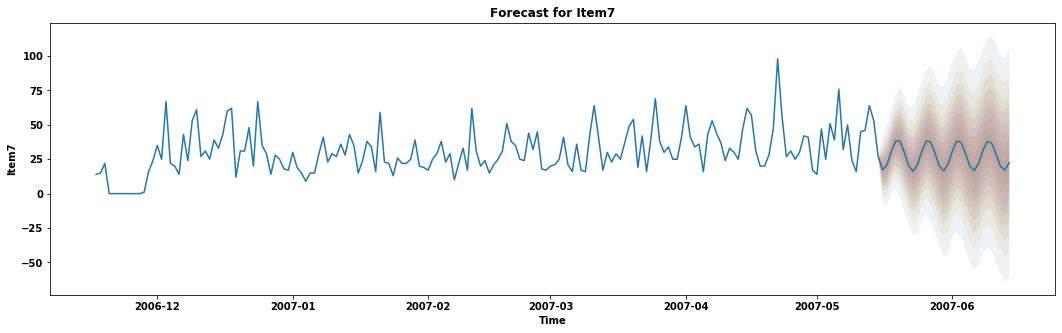

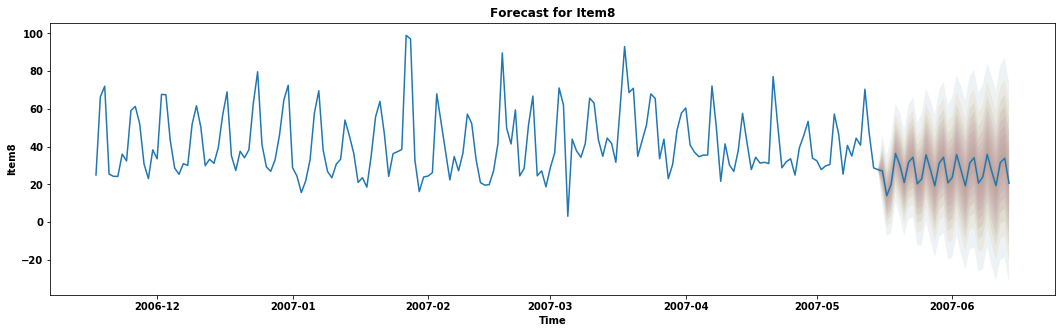

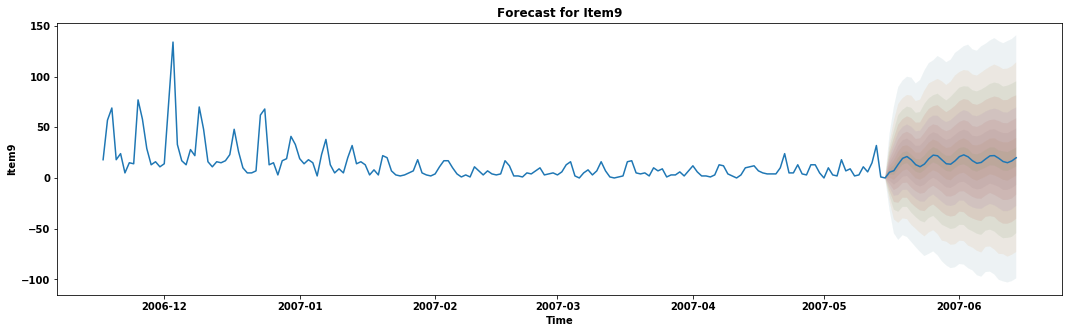

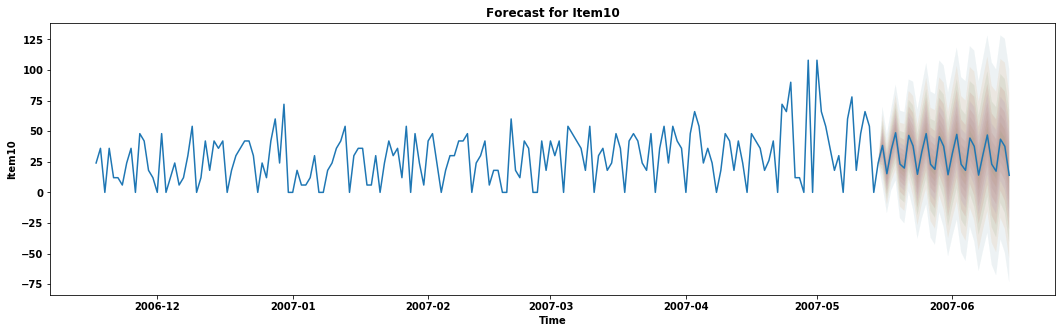

In [5]:
for col in seasonal_ts.columns:
    df = pd.DataFrame(seasonal_ts[col].dropna())
    model = pf.ARIMA(data=df, ar=4, ma=4, family=pf.Normal())
    model.fit()
    model.plot_predict(h=30,past_values=180,figsize=(18,5))

## Fbprophet
Посмотрим на то, какие fbprophet выдаёт базовые (без настраивания параметров) прогнозы на сезонные ВР

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


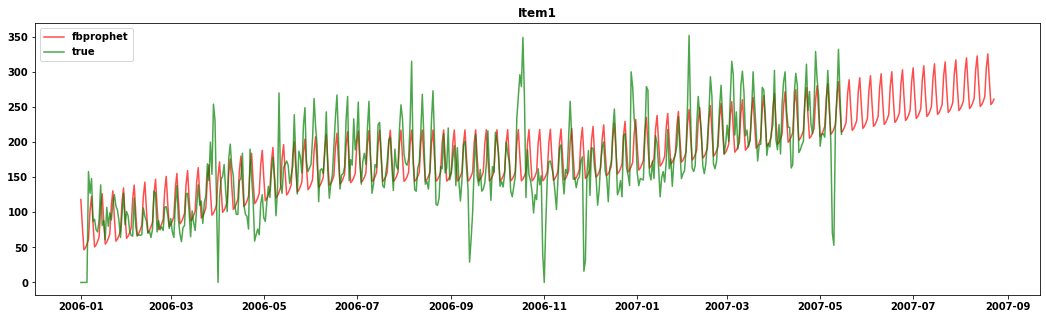

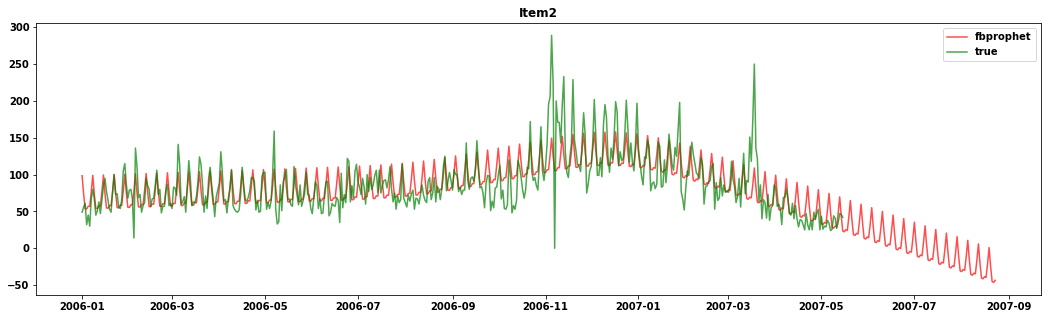

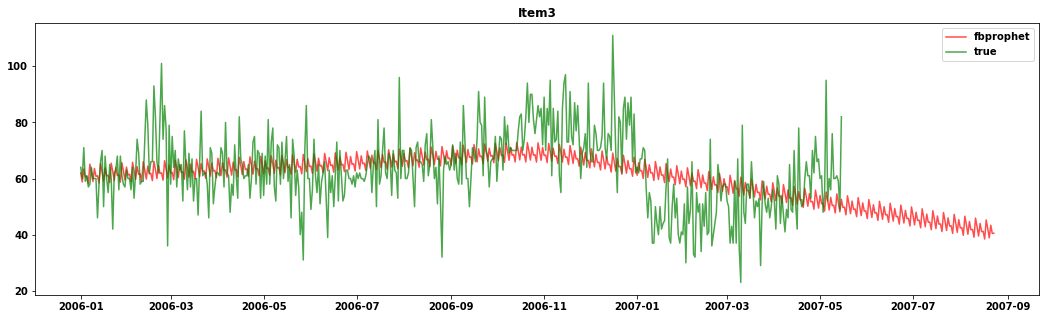

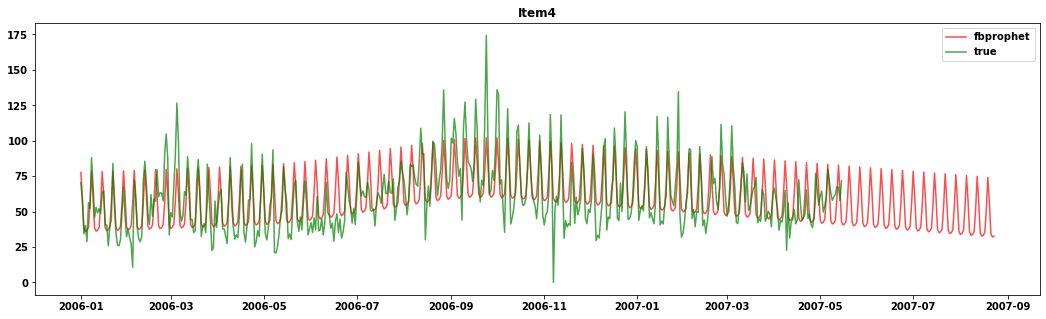

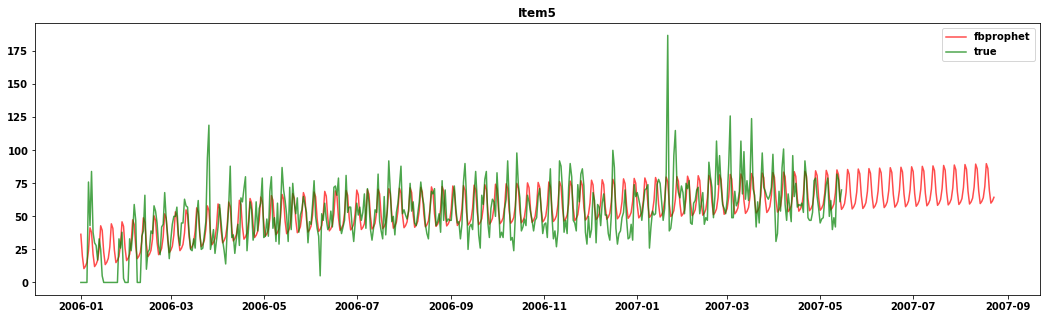

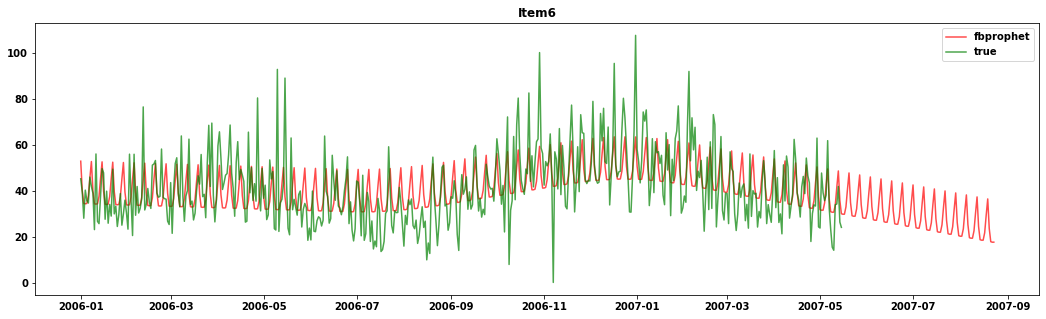

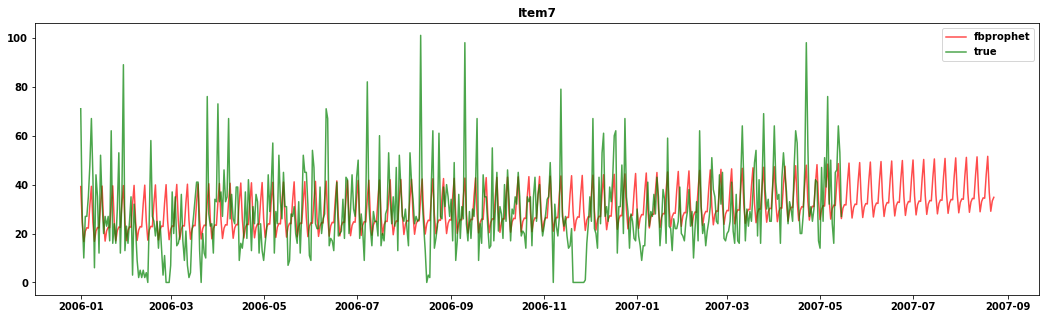

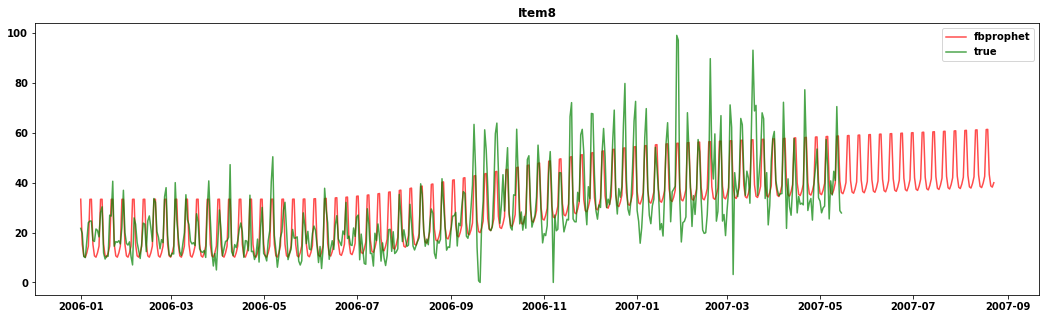

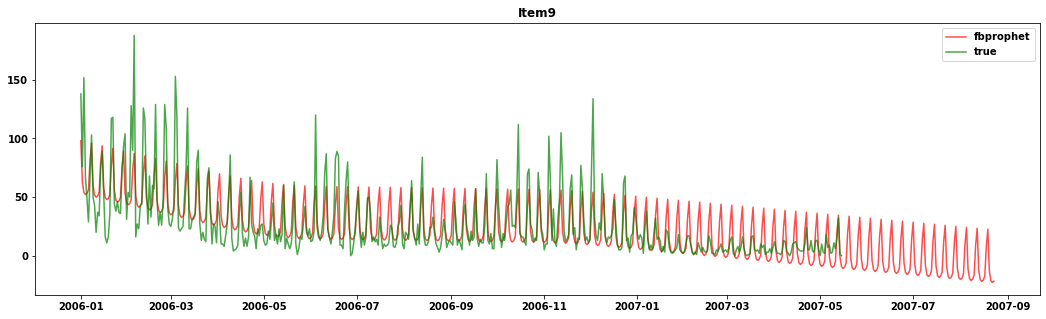

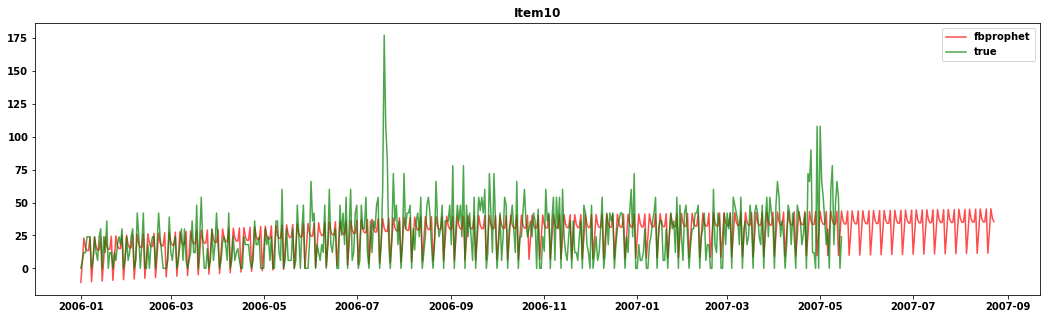

In [6]:
from fbprophet import Prophet

#suppressing the info logs
import logging
logging.getLogger('fbprophet').setLevel(logging.ERROR)

for col in seasonal_ts.columns:
    #creating a dataframe that fbprophet requires
    df = pd.DataFrame(seasonal_ts[col])
    df['ds'] = df.index
    df.columns = ['y', 'ds']
    
    #making predictions
    m = Prophet()
    m.fit(df)
    #'make_future_dataframe' parameter decides how far into the future we're looking
    future = m.make_future_dataframe(100)
    forecast = m.predict(future)
    
    #plotting the results
    plt.figure(figsize=(18,5))
    plt.plot(forecast['ds'], forecast['yhat'], color='red', alpha=0.7, label='fbprophet')
    plt.plot(df['y'], color='green', alpha=0.7, label='true')
    plt.title(col)
    plt.legend()
    plt.show();